# A simple word embedding experiment
Results: yeah, it works more or less well considering the amount of data. 

See:
- Pag 386 of Data Science from Scratch

## Plan
- data
    - hand-made sentences: what is the basic structure of a sentence? '"the" + color + noun + verb + adverb + adjective.'
    - what is the thing we predict and what is our target? predict: an embedding which is just a collection of numbers that it tries to adjust to the target | it serves as a proxy to improve the parameters of our embedding matrix, target: an embedding belonging to a specific word in our vocabulary.
- architecture
    - embedding layer + linear layer + softmax cross entropy
    - i imagine pytorch is going to take care of the gradients 
## Data
Our data is going to be handmade. We will feed our network in training pairs `(word,nearby_word)` and try to minimize the `SoftmaxCrossEntropy`.

In [61]:
import random
import torch.nn as nn
import torch

# let's start with the data
# we will create some random sentences with:
color = ['blue','red','green','yellow','white']
noun  = ['cat','dog','car','boat','house']
verb  = ['is','was','seems','looks']
adverb = ['quite','absurdly','extremely']
adjective = ['slow','fast','big','small']

# joining all these words following "the" + color + noun + verb + adverb + adjective.
num_sentences = 100
NUM_WORDS = len(color)+len(noun)+len(verb)+len(adverb)+len(adjective)

sentences = [" ".join([random.choice(color),random.choice(noun),random.choice(verb),random.choice(adverb),random.choice(adjective),'.']) for _ in range(num_sentences)]
random.sample(sentences,10)


['green car was absurdly big .',
 'green boat was quite fast .',
 'white cat was quite slow .',
 'red car was quite big .',
 'blue cat was extremely small .',
 'yellow boat was absurdly small .',
 'green cat was absurdly small .',
 'white dog is absurdly fast .',
 'yellow house is quite big .',
 'blue car looks absurdly slow .']

In [62]:
import re

# now we should assign indexes to words and viceversa to have some sort of mapping 
idx_to_word = {}
word_to_idx = {}

def get_one_hot(word):
    return [1.0 if i==word_to_idx[word] else 0.0 for i in range(NUM_WORDS)]

joined_words = color + noun + verb + adverb + adjective
for idx, word in enumerate(joined_words):
    idx_to_word[idx] = word
    word_to_idx[word] = idx

# we use redex to tokenize the senteces and obtain the training pairs
training_pairs = []
for sentence in sentences:
    tokenized_sentece = re.findall(r'\b\w+\b',sentence) # the `r` in r'\b\w+\b' indicates that the string should we treated as a raw string (because of the \)
    for i in range(len(tokenized_sentece)-1):
            training_pairs.append((tokenized_sentece[i],word_to_idx[tokenized_sentece[i+1]]))

for _ in random.sample(training_pairs,10):
     print(_)
     
# sanity check
#assert get_one_hot(training_pairs[1][0]) == [1.0 if i==word_to_idx[training_pairs[1][0]] else 0.0 for i in range(NUM_WORDS)]        

('extremely', 17)
('blue', 7)
('extremely', 20)
('was', 14)
('white', 5)
('red', 8)
('looks', 15)
('looks', 14)
('yellow', 8)
('was', 15)


## Architecture

<div style="text-align: center;">
    <img src="images/word_embedding_architecture.jpg" alt="image.png" style="width: 50%;"/>
    <figcaption>simple word embedding architecture.</figcaption>
</div>

Loss: 1.85: 100%|██████████| 400/400 [00:01<00:00, 366.83it/s]


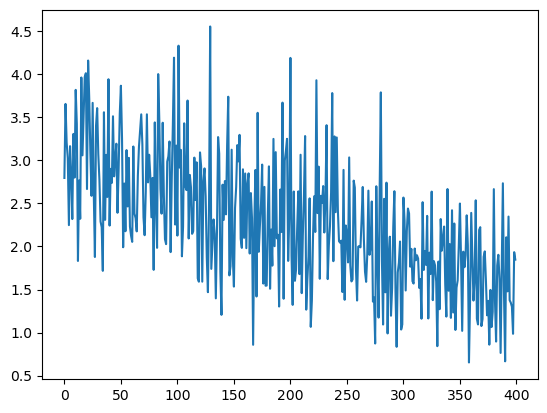

In [64]:
from tqdm import trange, tqdm
import matplotlib.pyplot as plt

class Embedding(nn.Module):
    # if all goes well the autograd is going to do what I wish it would do 
    def __init__(self,word_elements,embed_dimension):
        super().__init__()
        # initialize tensor with normal distribution of shape emb = (num_words,embed_dimension)
        self.embedding = nn.Parameter(torch.randn((word_elements, embed_dimension), requires_grad=True))
    
    def forward(self,word):
        """
        word: word string
        we will get the string id and return its embedding
        """
        return self.embedding[word_to_idx[word]]

class tinymodel(nn.Module):
    def __init__(self, num_words, embed_dimension):
        super().__init__()
        self.embedding = Embedding(num_words,embed_dimension)
        self.linear = nn.Linear(embed_dimension,num_words)
    def forward(self,word):
        embed = self.embedding(word)
        output = self.linear(embed)
        return output

# include the linear layer in our model | careful with the dimensions
EMBEDDING_SIZE = 10  
model = tinymodel(NUM_WORDS,EMBEDDING_SIZE)

# Training loop
epochs = len(training_pairs)
optim = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)
loss_function = nn.CrossEntropyLoss()

# keep track of loss function
losses = [] 

for i in (t := trange(epochs)):
    X,target = training_pairs[i]
    optim.zero_grad()
    prediction = model(X)
    loss = loss_function(prediction,torch.tensor(target))# order matters for the Cross Entropy Loss
    loss.backward()
    optim.step()

    loss = loss.item()
    losses.append(loss)

    t.set_description(f"Loss: {loss:.2f}")

plt.plot(losses)


In [79]:
# cosine similarity
def cosine_similarity(x,y):
    """
    x and y are strings
    """
    mat = model.embedding.embedding
    emb1 = mat[word_to_idx[x]]
    emb2 = mat[word_to_idx[y]]
    return nn.CosineSimilarity(dim=0)(emb1,emb2)

# --- Testing Cosine Similarity ---
print("\nSample Cosine Similarities:")
print("blue vs red:", cosine_similarity("blue", "red"))
print("cat vs dog:", cosine_similarity("cat", "dog"))
print("big vs small:", cosine_similarity("big", "small"))
print("car vs boat:", cosine_similarity("car", "boat"))
print("is vs white:", cosine_similarity("is", "white"))


Sample Cosine Similarities:
blue vs red: tensor(0.3970, grad_fn=<SumBackward1>)
cat vs dog: tensor(0.6778, grad_fn=<SumBackward1>)
big vs small: tensor(2.0850e-05, grad_fn=<SumBackward1>)
car vs boat: tensor(0.2362, grad_fn=<SumBackward1>)
is vs white: tensor(-0.2477, grad_fn=<SumBackward1>)
